# $\Huge Projekt$  $\Huge dyplomowy$


$\Large J.$  $\Large Witek$


# **Cel projektu**

Celem pracy jest porównanie istniejących algorytmów generujących model procesu na podstawie informacji wydobytych z logów systemowych. Opierając się na wybranym algorytmie, przedstawiono metodę przekształcającą wygenerowany model procesu do postaci równoważnej specyfikacji logicznej. Praca skupia się w szczególności na modelu procesu przedstawionym w notacji drzewa procesu, ze względu na jego prostą strukturę oraz gwarancję poprawności. Dodatkowym celem pracy jest weryfikacja wytworzonych specyfikacji logicznych przy użyciu systemów automatycznego dowodzenia twierdzeń logicznych dla logiki pierwszego rzędu. 

# **Przygotowanie środowiska**

## **Instalacja bibliotek**

In [ ]:
%pip install pm4py==2.7.4

In [ ]:
!apt install libgraphviz-dev

In [ ]:
!pip install pygraphviz

## **Importy**

In [ ]:
import pandas as pd
import os
import pm4py
import re
import json

from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
import pygraphviz as pgv
from IPython.display import Image, display
from datetime import datetime


In [ ]:
# EXAMPLE 1
log_1 = pm4py.read_xes("/content/running-example.xes")

# EXAMPLE 2
log_2 = pm4py.format_dataframe(pd.read_csv("repairExample.csv", sep=','),
                                   case_id='Case ID', activity_key='Activity',timestamp_key='Start Timestamp')

# **Dziennik zdarzeń**


Dane wejściowe do odkrycia procesu przechowywane są w dzienniku zdarzeń. W dzienniku zdarzeń możemy zwykle znaleźć wiele atrybutów, jednak większość algorytmów wykorzystywanych w eksploracji procesów potrzebuje trzech: identyfikatora przypadku, śladu czasu oraz nazwy samej czynności.

In [ ]:
log_1.head()

,concept:name,org:resource,time:timestamp,Activity,Resource,Costs,case:concept:name,case:creator
0,register request,Pete,2010-12-30 13:32:00+00:00,register request,Pete,50,3,Fluxicon Nitro
1,examine casually,Mike,2010-12-30 14:06:00+00:00,examine casually,Mike,400,3,Fluxicon Nitro
2,check ticket,Ellen,2010-12-30 15:34:00+00:00,check ticket,Ellen,100,3,Fluxicon Nitro
3,decide,Sara,2011-01-06 08:18:00+00:00,decide,Sara,200,3,Fluxicon Nitro
4,reinitiate request,Sara,2011-01-06 11:18:00+00:00,reinitiate request,Sara,200,3,Fluxicon Nitro


In [ ]:
log_1.shape

(42, 8)

In [ ]:
log_2.head()

,Case ID,Activity,Resource,Start Timestamp,Complete Timestamp,Variant,Variant index,(case) creator,(case) variant,(case) variant-index,...,defectType,lifecycle:transition,numberRepairs,org:resource,phoneType,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,1,Register,System,1970-01-02 12:23:00+00:00,1970-01-02 12:23:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,...,NaN,complete,NaN,System,NaN,1,Register,1970-01-02 12:23:00+00:00,0,0
1,1,Analyze Defect,Tester3,1970-01-02 12:23:00+00:00,1970-01-02 12:30:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,...,6,complete,NaN,Tester3,T2,1,Analyze Defect,1970-01-02 12:23:00+00:00,1,0
2,1,Repair (Complex),SolverC1,1970-01-02 12:31:00+00:00,1970-01-02 12:49:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,...,NaN,complete,NaN,SolverC1,NaN,1,Repair (Complex),1970-01-02 12:31:00+00:00,2,0
3,1,Test Repair,Tester3,1970-01-02 12:49:00+00:00,1970-01-02 12:55:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,...,NaN,complete,0,Tester3,NaN,1,Test Repair,1970-01-02 12:49:00+00:00,3,0
4,1,Inform User,System,1970-01-02 13:10:00+00:00,1970-01-02 13:10:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,...,NaN,complete,NaN,System,NaN,1,Inform User,1970-01-02 13:10:00+00:00,4,0


In [ ]:
log_2.shape

(8838, 21)

Zdarzenia występujące w dzienniku możemy pogrupować w obrębie jednego przypadku, a następnie na podstawie czasu początkowego stworzyć grupy będące tzw. śladami, które można zliczyć. Taka operacja pozwoli nam na identyfikacje wszystkich możliwych śladów.

In [ ]:
# EXAMPLE 1

#Routes discover
log_1_routes = (log_1
    .sort_values(by=['case:concept:name','time:timestamp'])
    .groupby(['case:concept:name'])
    .agg({'Activity': ';'.join})
)

#Routes counter
log_1_routes['count'] = 0

log_1_routes = (log_1_routes.groupby('Activity', as_index = False).count().sort_values(['count'], ascending = False).reset_index(drop=True))
log_1_routes.head()

,Activity,count
0,register request;check ticket;examine casually...,1
1,register request;check ticket;examine thorough...,1
2,register request;examine casually;check ticket...,1
3,register request;examine casually;check ticket...,1
4,register request;examine casually;check ticket...,1


In [ ]:
# EXAMPLE 2

#Routes discover
log_2['Start Timestamp'] = pd.to_datetime(log_2['Start Timestamp'])


log_2_routes = (log_2
    .sort_values(by=['Case ID','Start Timestamp'])
    .groupby(['Case ID'])
    .agg({'Activity': ';'.join})
)

#Routes counter
log_2_routes['count'] = 0
log_2_routes = (log_2_routes.groupby('Activity', as_index = False).count().sort_values(['count'], ascending = False).reset_index(drop=True))
log_2_routes.head()

,Activity,count
0,Register;Analyze Defect;Repair (Complex);Infor...,253
1,Register;Analyze Defect;Repair (Complex);Test ...,193
2,Register;Analyze Defect;Repair (Simple);Test R...,108
3,Register;Analyze Defect;Inform User;Repair (Co...,78
4,Register;Analyze Defect;Repair (Simple);Inform...,75


## **Graf bezpośrednich podążeń**

W grafie bezpośrednich podążeń wierzchołki odpowiadają zadaniom, a krawędzie odpowiadają relacji bezpośredniego podążania. Bezpośrednie podążanie oznacza wystąpienie jednego zdarzenia bezpośrednio po drugim w danym śladzie. Model ten daje pogląd na zachodzący proces, jednak w wielu przypadkach może być mylący.

In [ ]:
def draw_graph(log):

  log['trace'] = [trace.split(';') for trace in  log['Activity']]

  w_net = dict()
  ev_start_set = set()
  ev_end_set = set()
  for index, row in log[['trace','count']].iterrows():
    if row['trace'][0] not in ev_start_set:
      ev_start_set.add(row['trace'][0])
    if row['trace'][-1] not in ev_end_set:
      ev_end_set.add(row['trace'][-1])
    for ev_i, ev_j in pairwise(row['trace']):
      if ev_i not in w_net.keys():
        w_net[ev_i] = Counter()
      w_net[ev_i][ev_j] += row['count']

  G = pgv.AGraph(strict=False, directed=True)
  G.graph_attr['rankdir'] = 'LR'
  G.node_attr['shape'] = 'Mrecord'
  for event, succesors in w_net.items():
    G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
    G.add_edges_from([(event, sc) for sc in succesors])
  G.draw('simple_heuristic_net.png', prog='dot')
  display(Image('simple_heuristic_net.png'))

Z pierwszego dziennika zdarzeń udało się otrzymać następujący graf:

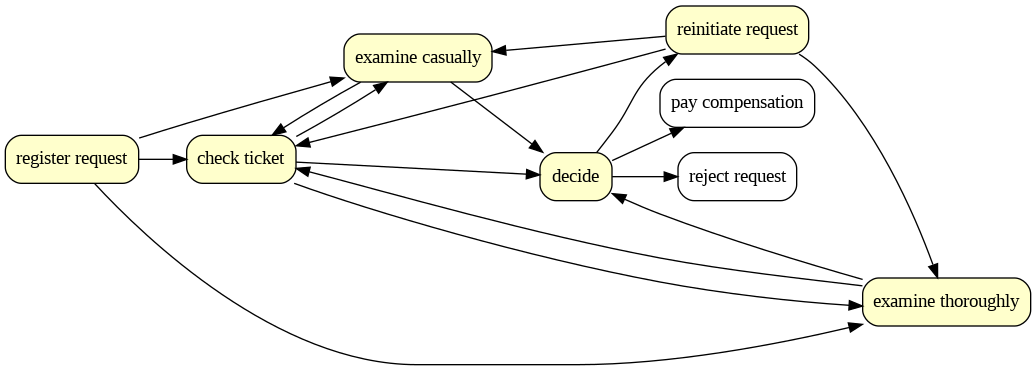

In [ ]:
draw_graph(log_1_routes)

Z drugiego dziennika zdarzeń otrzymano graf postaci:

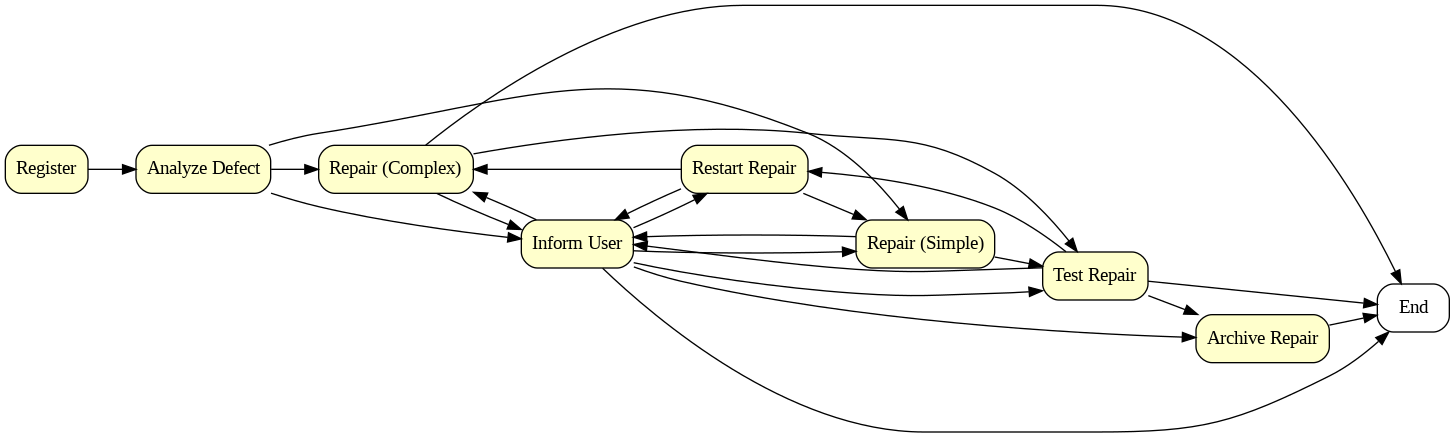

In [ ]:
draw_graph(log_2_routes)

Aby dokładniej zobrazować proces, możemy pokolorować zadania według ich wystąpień w dzienniku zdarzeń, a także dodać odpowiednie etykiety w zależności od tego,
jak często w logu występowało dane zdarzenie albo przepływ.

In [ ]:
def draw_graph(dfs, case_id, timestamp, activity):
  ev_counter = dfs.Activity.value_counts()
  dfs = (dfs
      .sort_values(by=[case_id, timestamp])
      .groupby([case_id])
      .agg({activity: ';'.join})
  )
  dfs['count'] = 0
  dfs = (
      dfs.groupby(activity, as_index=False).count()
      .sort_values(['count'], ascending=False)
      .reset_index(drop=True)
  )
  dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

  w_net = dict()
  ev_start_set = set()
  ev_end_set = set()
  for index, row in dfs[['trace','count']].iterrows():
      if row['trace'][0] not in ev_start_set:
          ev_start_set.add(row['trace'][0])
      if row['trace'][-1] not in ev_end_set:
          ev_end_set.add(row['trace'][-1])
      for ev_i, ev_j in pairwise(row['trace']):
          if ev_i not in w_net.keys():
              w_net[ev_i] = Counter()
          w_net[ev_i][ev_j] += row['count']

  trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
  trace_min = trace_counts[0]
  trace_max = trace_counts[-1]
  color_min = ev_counter.min()
  color_max = ev_counter.max()

  G = pgv.AGraph(strict= False, directed=True)
  G.graph_attr['rankdir'] = 'LR'
  G.node_attr['shape'] = 'Mrecord'

  G.add_node("start", shape="circle", label="")
  for ev_start in ev_start_set:
    G.add_edge("start", ev_start)

  for event, succesors in w_net.items():
    value = ev_counter[event]
    color = int(float(color_min-value)/float(color_min-color_max)*100.00)
    label = str(event) + ": " + str(ev_counter[event])
    my_color = "#ff9933"+str(hex(color))[2:]
    G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
    for succesor, cnt in succesors.items():
      G.add_edge(event, succesor, penwidth=4*cnt/(trace_max-trace_min)+0.1, label=cnt)

  G.add_node("end", shape="circle", label="", penwidth='3')
  for ev_end in ev_end_set:
    G.add_edge(ev_end, "end")

  G.draw('simple_heuristic_net_with_events.png', prog='dot')
  display(Image('simple_heuristic_net_with_events.png'))

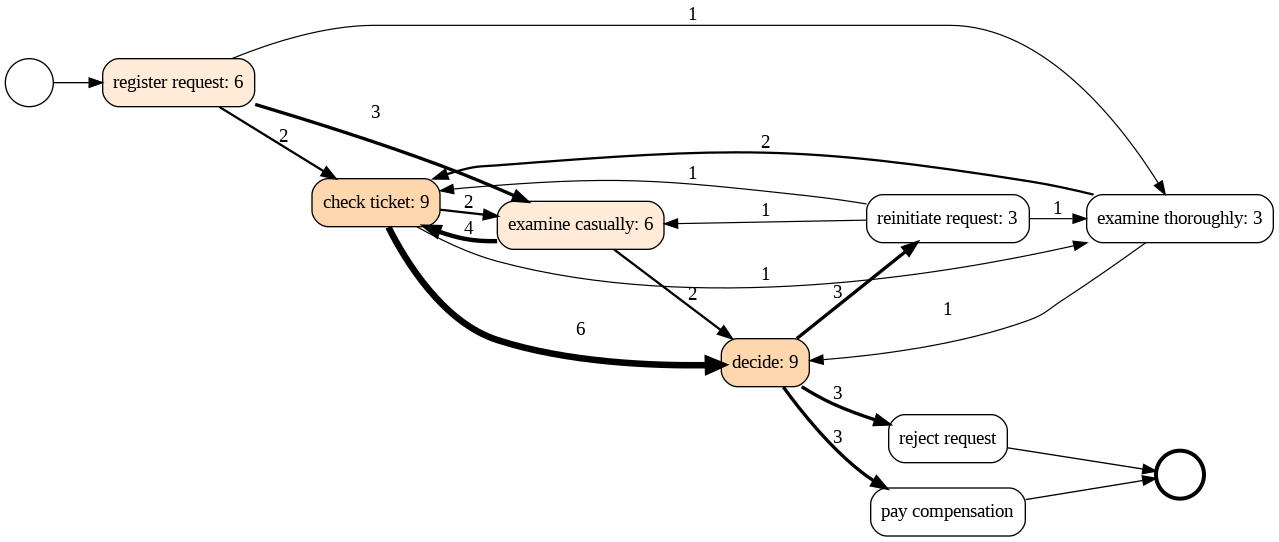

In [ ]:
draw_graph(log_1, 'case:concept:name', 'time:timestamp', 'Activity')

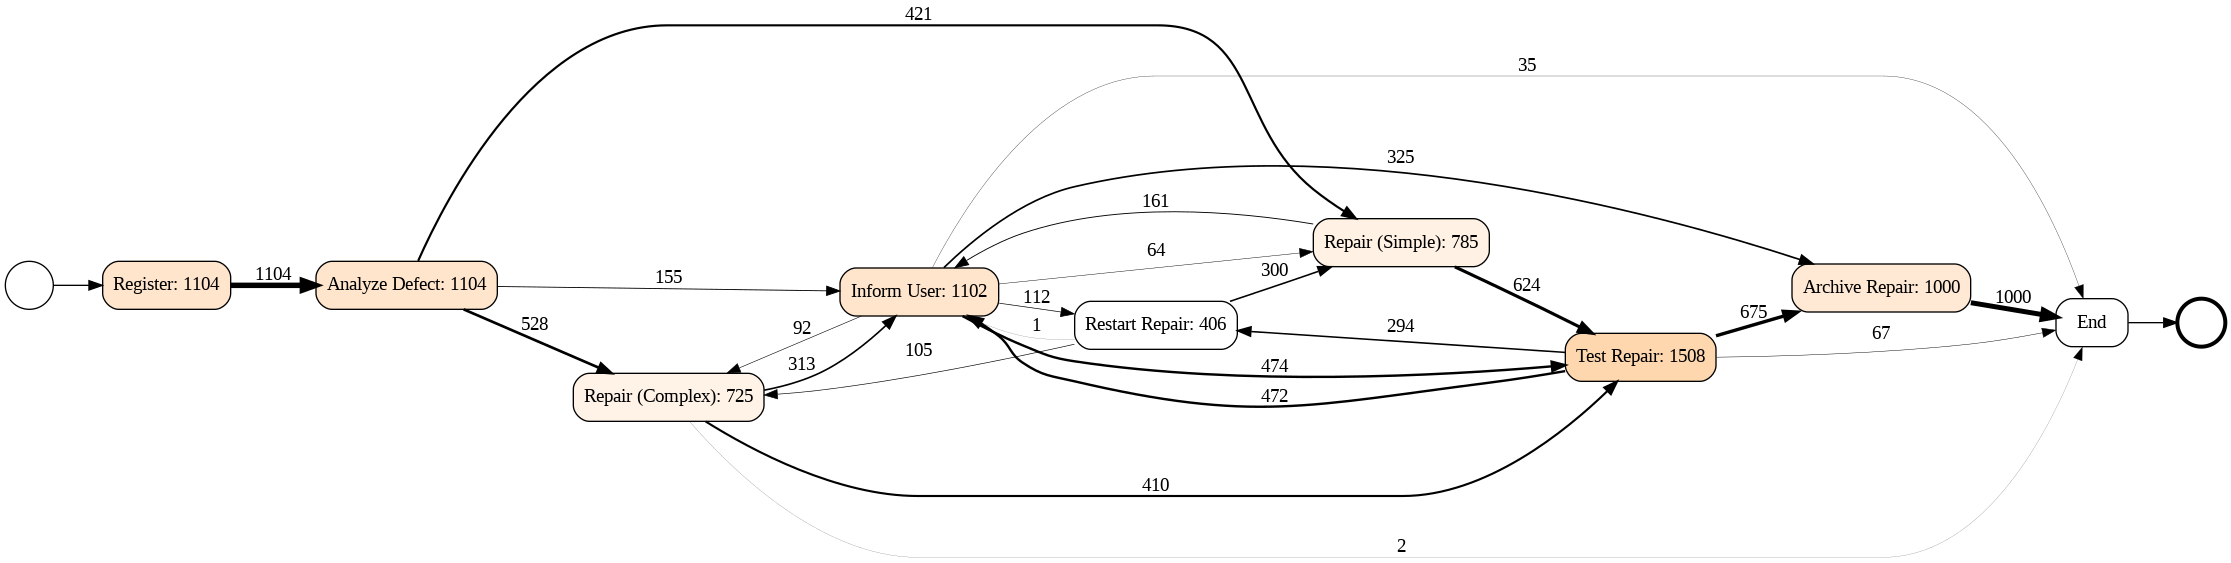

In [ ]:
draw_graph(log_2, 'Case ID', 'Start Timestamp', 'Activity')

Celem eksploracji procesów jest przekształcenie danych o zdarzeniach w schematy, będące punktem wyjścia do analizy wydajności procesów. Dane wykorzystywane w eksploracji procesu, przekazywane w postaci dzienników zdarzeń, są następnie przekształcane w pewne notacje. W celu przekształcenia dziennika zdarzeń do wybranej notacji można skorzystać z gotowego algorytmu. Do przykładowych algorytmów stosowanych w eksploracji procesów należą Alpha Miner, Inductive Miner czy Heuristic Miner. Algorytm Alpha Miner generuje model w postaci sieci Petriego, Heuristic Miner w postaci sieci Heurystycznej, natomiast za pomocą Inductive Miner można otrzymać zarówno sieć Petriego jak i drzewo procesu. Ponadto czasami możliwe jest przekonwertowanie sieci otrzymanej przez Alpha Miner bądź Heuristic Miner do postaci drzewa. Aby przekonwertować sieć Petriego pewnego procesu na drzewo procesu, konieczne jest spełnienie dwóch warunków: sieć musi być poprawna i posiadać strukturę blokową. W praktyce oznacza to, że nie wszystkie odkryte sieci procesu w postaci sieci Petriego mogą być reprezentowane jako drzewa procesu.

# **Implementacja z wykorzystanie biblioteki PM4PY**

PM4Py (Process Mining for Python) to biblioteka open source służąca do analizy procesów biznesowych. Jednym z głównych obszarów funkcjonalnych tej biblioteki jest zapewnienie implementacji różnych algorytmów odkrywania procesów, w tym Alpha Miner, Heuristics Miner czy Inductive Miner. Biblioteka oferuje również narzędzia do wizualizacji, które umożliwiają tworzenie graficznych reprezentacji procesów, takich jak sieci Petriego czy drzewa procesów.

[Dokumentacja PM4Py](https://pm4py.fit.fraunhofer.de/documentation)

### **Alpha Miner**



In [ ]:
# EXAMPLE 1

Alpha Miner jest jednym z najbardziej znanych algorytmów eksploracji procesów i jest w stanie znaleźć:

* Model sieci Petriego, w którym wszystkie przejścia są widoczne i niepowtarzalne oraz odpowiadają sklasyfikowanym zdarzeniom.
* Miejsce początkowe opisujące stan modelu sieci Petriego w momencie rozpoczęcia wykonywania.
* Miejsce końcowe opisujące stan modelu sieci Petriego po zakończeniu wykonania.




Zwizualizujmy więc sieć Petriego na podstawie algorytmu Alpha Miner.

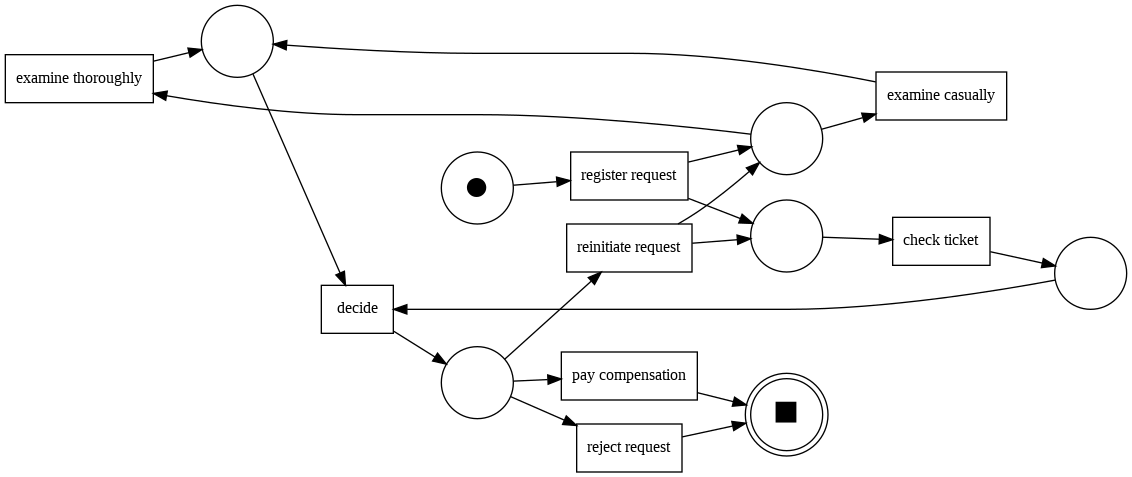

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_1)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

Sprawdźmy czy jest możliwe przekonwertownie powyższej sieci do postaci drzewa procesu:

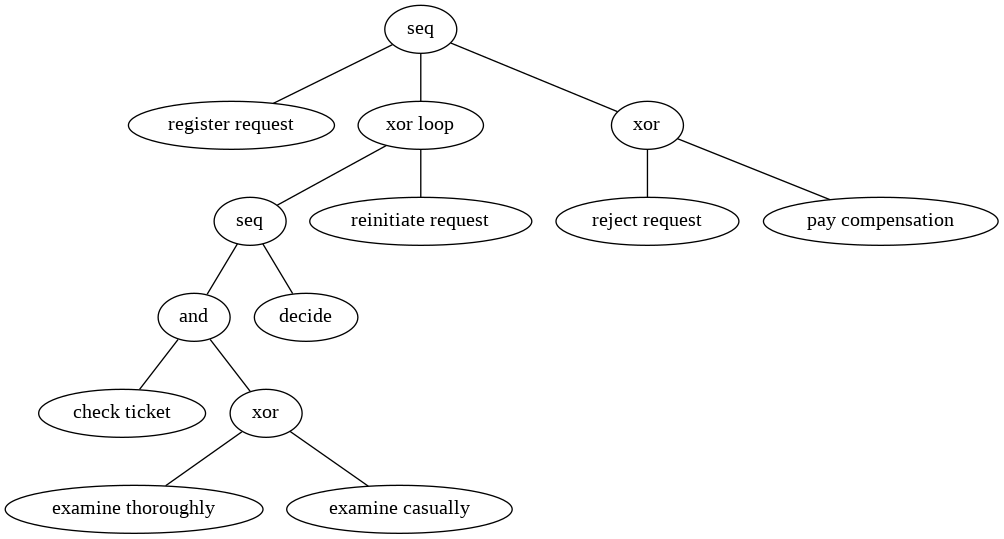

In [ ]:
try:
  tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
  pm4py.view_process_tree(tree)
except ValueError:
  print("Parsing of WF-net Failed")

Podany dziennik zdarzeń da  się sprowadzić do postaci drzewa z wykorzystaniem algorytmu Alpha Miner.

In [ ]:
# EXAMPLE 2

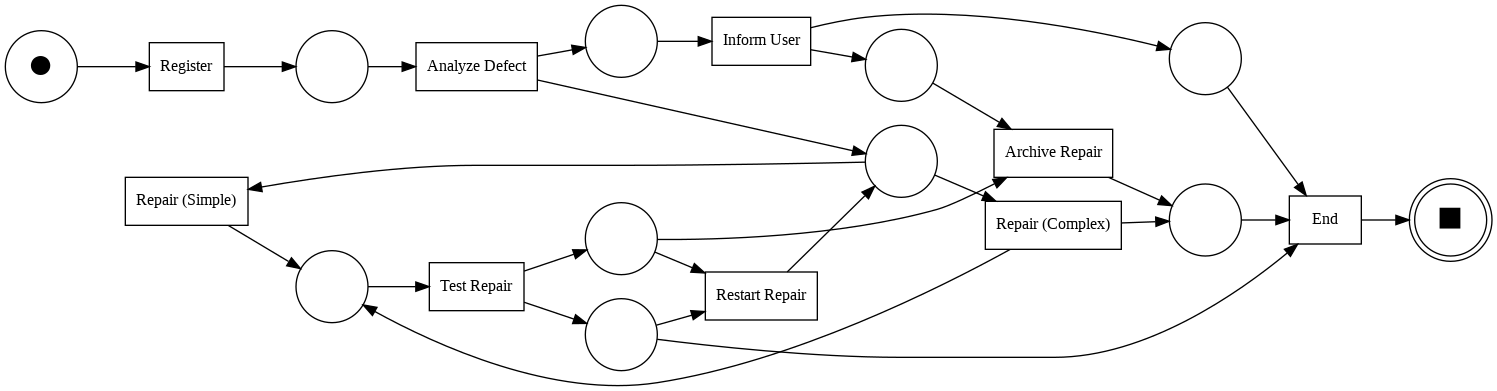

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_2)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

Sprawdźmy czy jest możliwe przekonwertownie powyższej sieci do postaci drzewa procesu:

In [ ]:
try:
  tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
  pm4py.view_process_tree(tree)
except ValueError:
  print("Parsing of WF-net Failed")

Parsing of WF-net Failed


Sieć Petriego otrzymana na podstawie tego dziennika zdarzeń, w przypadku użycia algorytmu Alpha Miner nie daje sprowadzić się do drzewa procesów. Otrzymana Sieć Petriego nie jest poprawna.

### **Inductive Miner**

Algorytmy z tej grupy zwracają model w postaci drzewa procesu. Konwersja drzewa
procesu w sieć procesu jest łatwo osiągalna, a uzyskana sieć jest zawsze poprawna. W ramach działania algorytmu tworzony jest graf bezpośrednich podążeń, w ramach którego dokonywany jest podział logów. W wyniku podziału powstają pod-logi, które następnie poddaje się dalszym podziałom, do momentu
pozostania jedynie jednej aktywności. Operacja podziału logów oparta jest
o wzorce: sekwencyjny (→), wyłącznego wyboru (×), równoległości (∧) oraz pętli (⟳). Gdy
wzorzec zostanie rozpoznany, jego symbol umieszczany jest jako wierzchołek drzewa, a powstałe
pod-logi umieszczane są na galęziach.

Biblioteka PM4PY umożliwia otrzymanie dwóch modeli procesów: sieci Petriego oraz drzewa.
Aby uzyskać sieć Petriego odczytywany jest dziennik zdarzeń, nakładany jest algorytm Inductive Miner oraz odnajdywana jest sieć Petriego wraz z początkowym i końcowym oznaczeniem.

In [ ]:
# EXAMPLE 1

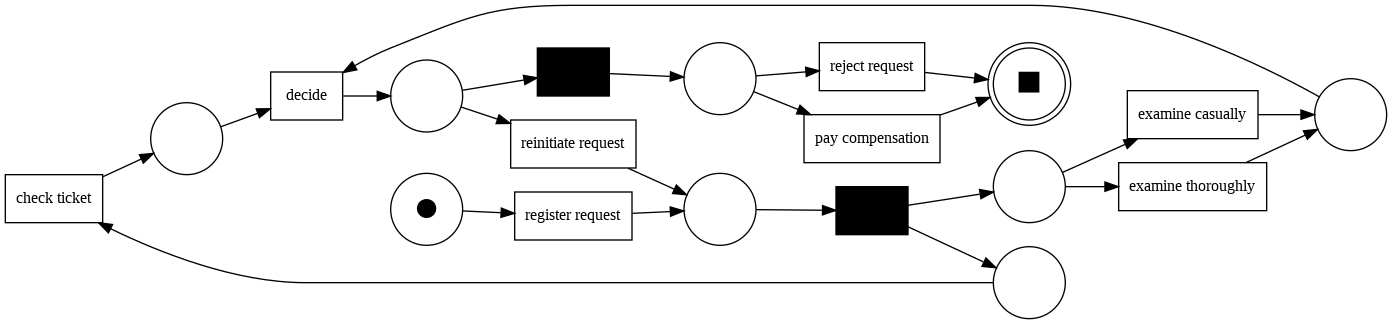

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_1)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

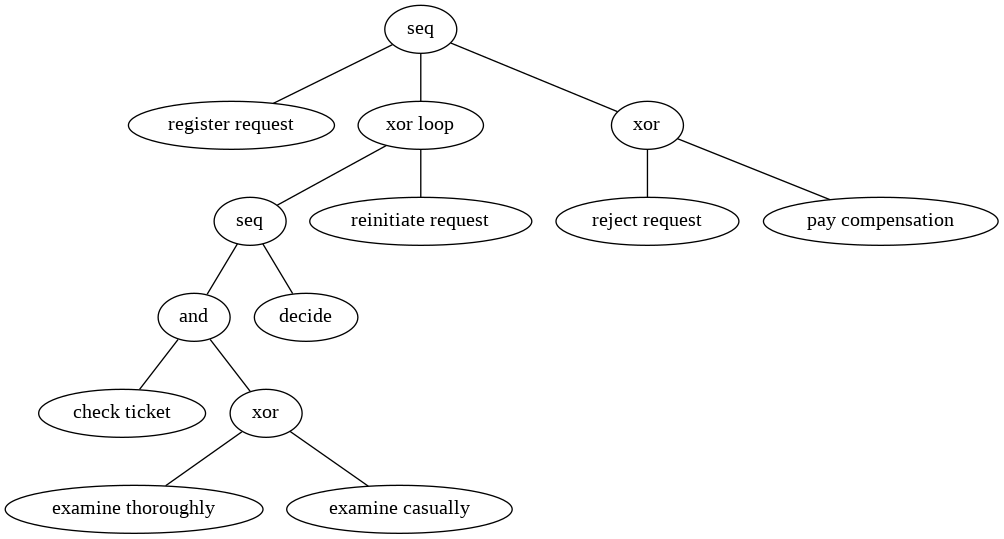

In [ ]:
tree_1 = pm4py.discover_process_tree_inductive(log_1)

pm4py.view_process_tree(tree_1)

Możemy zauważyć, że otrzymane drzewo procesu ma identyczną formę co w przypadku algorytmu Inductive Miner

In [ ]:
# EXAMPLE 2

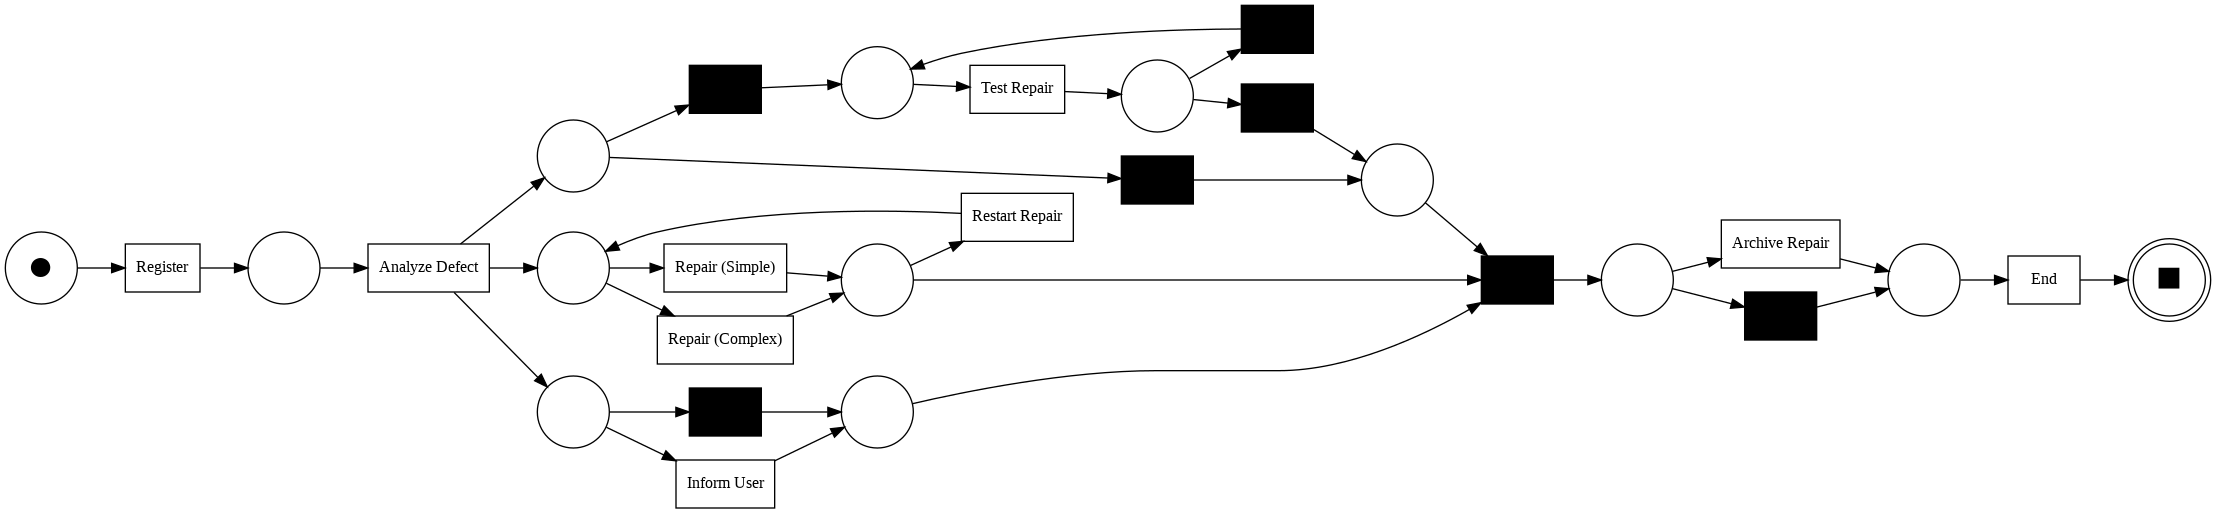

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_2)

pm4py.view_petri_net(net, initial_marking, final_marking, format="png")

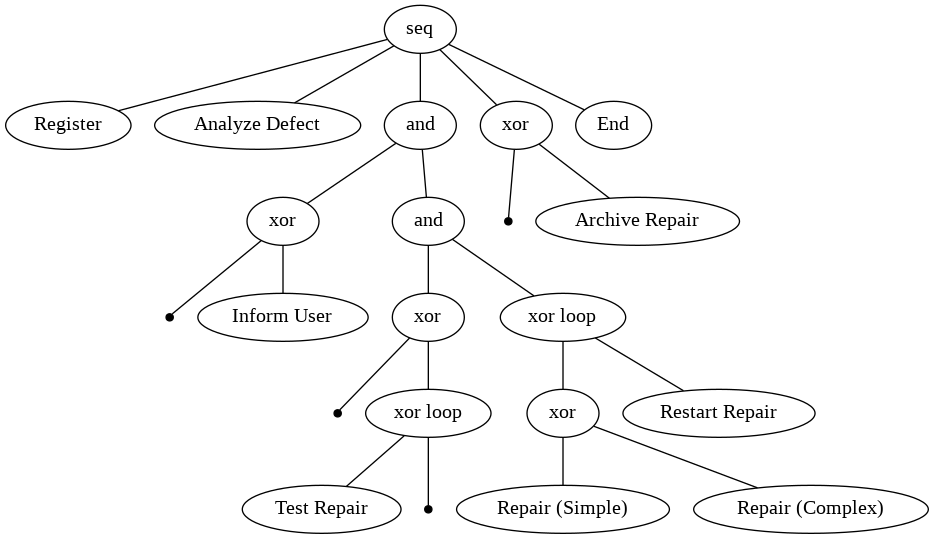

In [ ]:
tree_2 = pm4py.discover_process_tree_inductive(log_2)

pm4py.view_process_tree(tree_2)

Biblioteka PM4Py posiada także implementacje modyfikacji algorytmu Inductive Miner - Inductive Miner infrequent. Aby skorzystać z filtracji trzeba zmienić parametr wejściowy noise_threshold z wartości domyślnej wynoszącej 0 na dowolną wartość z zakresu od 0 do 1. Parametr ten dotyczy stopnia ignorowania zakłóceń w dzienniki zdarzeń. Warto zauważyć, że gdy noise_threshold ustawiony jest na wartość 0 to wytworzony model ma stuprocentową trafność natomiast nie jest do końca precyzyjny. Zastosowanie filtracji poprzez użycie algorytmu Inductive Miner infrequent pozwala na poprawę precyzji, zachowując przy tym dość dobrą trafność.

Ponieważ drzewo procesu otrzymane dla dziennika zdarzeń log_2 ma dość skomplikowaną strukturę, postanowiono sprawdzić jak zastosowanie filtracji wpłynie na formę tego drzewa.

In [ ]:
# EXAMPLE 3

Drzewo procesu dla dziennika zdarzeń log_2 przy wartości parametru progu zaszumienia wynoszącej 0.5:

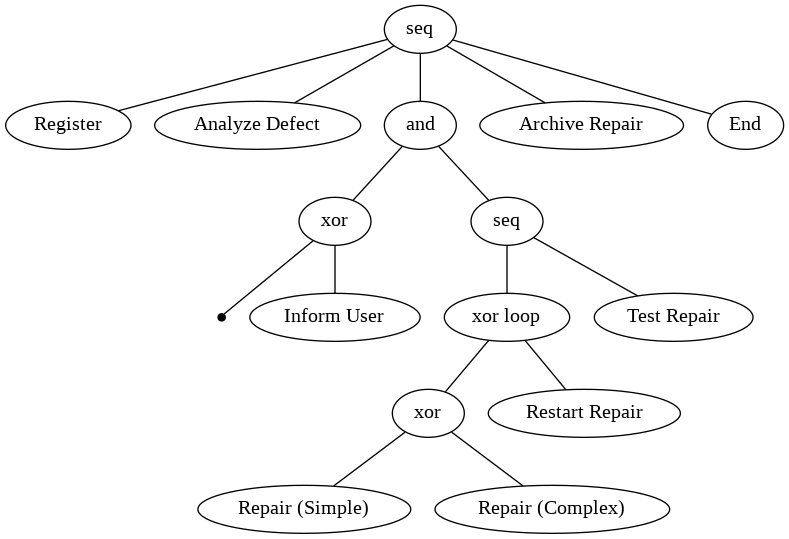

In [ ]:
tree_3 = pm4py.discover_process_tree_inductive(log_2, 0.5)

pm4py.view_process_tree(tree_3)

In [ ]:
# EXAMPLE 4

Drzewo procesu dla dziennika zdarzeń log_2 przy wartości parametru progu zaszumienia wynoszącej 1:

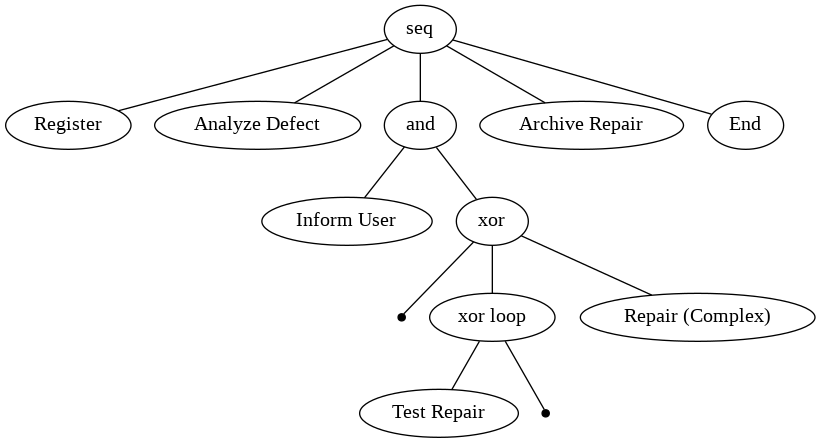

In [ ]:
tree_4 = pm4py.discover_process_tree_inductive(log_2, 1)

pm4py.view_process_tree(tree_4)

Równoważnym zapisem powyższych drzew procesu są wyrażenia wzorcowe W następującej postaci:

In [ ]:
# EXAMPLE 1

Wyrażenie W1:

In [ ]:
W1 = str(tree_1)
print(W1)

->( 'register request', *( ->( +( 'check ticket', X( 'examine casually', 'examine thoroughly' ) ), 'decide' ), 'reinitiate request' ), X( 'pay compensation', 'reject request' ) )


In [ ]:
# EXAMPLE 2

Wyrażenie W2:

In [ ]:
W2 = str(tree_2)
print(W2)

->( 'Register', 'Analyze Defect', +( X( tau, 'Inform User' ), +( X( tau, *( 'Test Repair', tau ) ), *( X( 'Repair Simple', 'Repair Complex' ), 'Restart Repair' ) ) ), X( tau, 'Archive Repair' ), 'End' )


In [ ]:
# EXAMPLE 3

Wyrażenie W3:

In [ ]:
W3 = str(tree_3)
print(W3)

->( 'Register', 'Analyze Defect', +( X( tau, 'Inform User' ), ->( *( X( 'Repair Simple', 'Repair Complex' ), 'Restart Repair' ), 'Test Repair' ) ), 'Archive Repair', 'End' )


In [ ]:
# EXAMPLE 4

Wyrażenie W4:

In [ ]:
W4 = str(tree_4)
print(W4)

->( 'Register', 'Analyze Defect', +( 'Inform User', X( tau, 'Repair Complex', *( 'Test Repair', tau ) ) ), 'Archive Repair', 'End' )


# **Generowanie specyfikacji logicznej**

Założeniem projektu było zaimplementowanie rozwiązania umożliwiającego automatyczne generowanie specyfikacji logicznych w oparciu o wybrane zatwierdzone wzorce przepływu oraz bezpośrednio z nimi powiązane, predefiniowane wzorce logiczne.  Jako pośredni model procesu wybrano drzewo procesu, które zostało otrzymane na podstawie dziennika zdarzeń, a etykiety drzewa posłużyły do definicji zatwierdzonych wzorców przepływu. Uzyskana specyfikacja logiczna może być następnie użyta do automatycznej weryfikacji poprawności działania systemu poprzez zastosowanie jednego z dostępnych systemów automatycznego dowodzenia twierdzeń. Takie podejście umożliwi bardziej efektywne badanie i weryfikację zachowań analizowanego systemu.

Stworzony system składa się z 4 elementów:


1.   Generator drzewa procesu (generator wyrażeń W przedstawiony wyżej)
2.   Konwerter wzorców z drzewa procesu do zatwierdzonych wzorców przepływu
3.   Predefiniowane wzorce logiczne
4.   Algorytm konwertujący drzewo procesu do postaci specyfikacji logicznej


### **Konwersja wzorców z drzewa procesu do zatwierdzonych wzorców przepływu**

**ProcessTreeAdapter**

In [ ]:
class ProcessTreeAdapter:

    @staticmethod
    def remove_brackets_between_single_quotes(expression):
        pattern = r"'(.*?)'"
        matches = re.findall(pattern, expression)

        for match in matches:
            replaced = match.replace('(', '').replace(')', '')
            expression = expression.replace(f"'{match}'", f"'{replaced}'")
        return expression

    @staticmethod
    def label_expressions(expression: str) -> str:
        labelled_expression = ""
        label_number = 0
        for c in expression:
            if c == '(':
                label_number += 1
                labelled_expression += f"({label_number}]"
            elif c == ')':
                labelled_expression += f"[{label_number})"
                label_number -= 1
            else:
                labelled_expression += c
        return labelled_expression

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression):
        pattern_label_number = int(labelled_expression[-2])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1:-3]
        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""
        return arguments, pattern_label_number

    @staticmethod
    def find_symbol(labelled_expression):
        pattern = r'^[^()]*'
        match = re.match(pattern, labelled_expression)
        if match:
            return re.sub(r'\s+', '', match.group())
        else:
            raise Exception("No match")

    @staticmethod
    def replace_spaces_with_underscore(tree):
        def replace_spaces(match):
            return re.sub(r'\s+', '_', match.group(0))

        text_with_underscore = re.sub(r"'(.*?)'", replace_spaces, tree)
        text_no_quotes = re.sub(r"'", '', text_with_underscore)

        return text_no_quotes

    @staticmethod
    def replace_symbol_with_name(labelled_pattern_expression, pattern_label_number, old_symbol, new_name):
        pattern = rf"{re.escape(old_symbol)}\(({pattern_label_number}\])"
        new_name = new_name + "(" + str(pattern_label_number) + "]"
        replaced_string = re.sub(pattern, new_name, labelled_pattern_expression)

        return replaced_string

    @staticmethod
    def get_highest_label(labelledExpression: str) -> int:
        maxLabel = -1
        active = False
        sb = ""
        for c in labelledExpression:
            if c == '(':
                active = True
            elif c == ']':
                if int(sb) > maxLabel:
                    maxLabel = int(sb)
                sb = ""
                active = False
            elif active:
                sb += c
        return maxLabel

**Usunięcie nawisów okrągłych w nazwach czynności**

In [ ]:
W1 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W1)
W2 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W2)
W3 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W3)
W4 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W4)

In [ ]:
print(W1)
print(W2)
print(W3)
print(W4)

->( 'register request', *( ->( +( 'check ticket', X( 'examine casually', 'examine thoroughly' ) ), 'decide' ), 'reinitiate request' ), X( 'pay compensation', 'reject request' ) )
->( 'Register', 'Analyze Defect', +( X( tau, 'Inform User' ), +( X( tau, *( 'Test Repair', tau ) ), *( X( 'Repair Simple', 'Repair Complex' ), 'Restart Repair' ) ) ), X( tau, 'Archive Repair' ), 'End' )
->( 'Register', 'Analyze Defect', +( X( tau, 'Inform User' ), ->( *( X( 'Repair Simple', 'Repair Complex' ), 'Restart Repair' ), 'Test Repair' ) ), 'Archive Repair', 'End' )
>(Register, Analyze_Defect, +(Inform_User, X(tau, Repair_Complex, *(Test_Repair, tau))), Archive_Repair, End)


**Zamiana spacji na podkreślnik w nazwach czynności**

In [ ]:
W1 = ProcessTreeAdapter.replace_spaces_with_underscore(W1)
W1 = W1.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W2 = ProcessTreeAdapter.replace_spaces_with_underscore(W2)
W2 = W2.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W3 = ProcessTreeAdapter.replace_spaces_with_underscore(W3)
W3 = W3.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

W4 = ProcessTreeAdapter.replace_spaces_with_underscore(W4)
W4 = W4.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")

In [ ]:
print(W1)
print(W2)
print(W3)
print(W4)

>(register_request, *(>(+(check_ticket, X(examine_casually, examine_thoroughly)), decide), reinitiate_request), X(pay_compensation, reject_request))
>(Register, Analyze_Defect, +(X(tau, Inform_User), +(X(tau, *(Test_Repair, tau)), *(X(Repair_Simple, Repair_Complex), Restart_Repair))), X(tau, Archive_Repair), End)
>(Register, Analyze_Defect, +(X(tau, Inform_User), >(*(X(Repair_Simple, Repair_Complex), Restart_Repair), Test_Repair)), Archive_Repair, End)
>(Register, Analyze_Defect, +(Inform_User, X(tau, Repair_Complex, *(Test_Repair, tau))), Archive_Repair, End)


**Numerowanie zagnieżdżeń**

In [ ]:
labelled_pattern_expression1 = ProcessTreeAdapter.label_expressions(W1)
labelled_pattern_expression2 = ProcessTreeAdapter.label_expressions(W2)
labelled_pattern_expression3 = ProcessTreeAdapter.label_expressions(W3)
labelled_pattern_expression4 = ProcessTreeAdapter.label_expressions(W4)

In [ ]:
print(labelled_pattern_expression1)
print(labelled_pattern_expression2)
print(labelled_pattern_expression3)
print(labelled_pattern_expression4)

>(1]register_request, *(2]>(3]+(4]check_ticket, X(5]examine_casually, examine_thoroughly[5)[4), decide[3), reinitiate_request[2), X(2]pay_compensation, reject_request[2)[1)
>(1]Register, Analyze_Defect, +(2]X(3]tau, Inform_User[3), +(3]X(4]tau, *(5]Test_Repair, tau[5)[4), *(4]X(5]Repair_Simple, Repair_Complex[5), Restart_Repair[4)[3)[2), X(2]tau, Archive_Repair[2), End[1)
>(1]Register, Analyze_Defect, +(2]X(3]tau, Inform_User[3), >(3]*(4]X(5]Repair_Simple, Repair_Complex[5), Restart_Repair[4), Test_Repair[3)[2), Archive_Repair, End[1)
>(1]Register, Analyze_Defect, +(2]Inform_User, X(3]tau, Repair_Complex, *(4]Test_Repair, tau[4)[3)[2), Archive_Repair, End[1)


**Zmiana etykiet drzewa procesu na zatwierdzone wzorce przepływu**

W oparciu o etykiety występujące w drzewie procesu (czy też wyrażeniu W) oraz ilość zadań podlegających pod każdą z tych etykiet, zdefiniowano następujący zestaw zatwierdzonych wzorców przepływu:

Σ = {Seq2, Seq3, Seq4, Seq5, Xor2, Xor3, And2, And3, Loop}

Każda z etykiet wzorców występujących w wyrażeniu W tj. ->, X, +, * zostaje zamieniona na nazwę odpowiadającego jej zatwierdzonego wzorca przepływu.

In [ ]:
class Sequence:
    @staticmethod
    def change_symbol_into_name(labelled_expression):
        pattern_symbol = '>'
        pattern_name = 'Seq'
        if len(labelled_expression) == 2:
            pattern_name = 'Seq2'
        elif len(labelled_expression) == 3:
            pattern_name = 'Seq3'
        elif len(labelled_expression) == 4:
            pattern_name = 'Seq4'
        elif len(labelled_expression) == 5:
            pattern_name = 'Seq5'
        else:
            raise Exception("pattern does not exist")
        return pattern_name

class Loop:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = '*'
        pattern_name = 'Loop'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            labelled_expression = ['l_s'] + labelled_expression
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class ExclusiveChoice:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = 'X'
        pattern_name = 'Xor'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            pattern_name = 'Xor2'
            labelled_expression = ['x2_s'] + labelled_expression + ['x2_e']
        elif len(labelled_expression) == 3:
            pattern_name = 'Xor3'
            labelled_expression = ['x3_s'] + labelled_expression + ['x3_e']
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class Parallelism:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = '+'
        pattern_name = 'And'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            pattern_name = 'And2'
            labelled_expression = ['a2_s'] + labelled_expression + ['a2_e']
        elif len(labelled_expression) == 3:
            pattern_name = 'And3'
            labelled_expression = ['a3_s'] + labelled_expression + ['a3_e']
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression


**PatternExpressionGenerator**

In [ ]:
class PatternExpressionGenerator:
    def __init__(self, converted_expression):
        self.converted_expression = converted_expression

    def add_approved_workflow_patterns(self, expression):
          if expression == None or isinstance(expression , list):
            return

          symbol = ProcessTreeAdapter.find_symbol(expression)
          pattern = r'>|X|\+|\*'
          matches = re.findall(pattern, expression)

          if (len(matches) != 0):
            arguments = ProcessTreeAdapter.extract_arguments_from_labelled_expression(expression)
            expression = arguments[0]
            pattern_label_number = arguments[1]
            if symbol == '>':
                new_name = Sequence.change_symbol_into_name(expression)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name)
            elif symbol == '*':
                new_name = Loop.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])
                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            elif symbol == '+':
                new_name = Parallelism.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])

                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            elif symbol == 'X':
                new_name = ExclusiveChoice.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])
                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            else:
                raise Exception("pattern does not exist")
          return expression

    def get_converted_expression(self):
        return self.converted_expression



In [ ]:
def process_patterns(pattern_list, instance):
    new_pattern_list = []
    for pattern in pattern_list:
        new_pattern = instance.add_approved_workflow_patterns(pattern)
        if isinstance(new_pattern, list):
            new_pattern = process_patterns(new_pattern, instance)
        new_pattern_list.append(new_pattern)
    return new_pattern_list

def recursive_process(pattern_list, instance, depth):
    if depth <= 0:
        return pattern_list
    else:
        pattern_list = process_patterns(pattern_list, instance)
        return recursive_process(pattern_list, instance, depth - 1)

def get_pattern_expression(labelled_pattern_expression):
    pattern_list = []
    pattern_list.append(labelled_pattern_expression)
    pattern_expression_generator = PatternExpressionGenerator(labelled_pattern_expression)
    recursive_process(pattern_list, pattern_expression_generator, ProcessTreeAdapter.get_highest_label(labelled_pattern_expression))

    return pattern_expression_generator.get_converted_expression()

In [ ]:
pattern_expression1 = get_pattern_expression(labelled_pattern_expression1)
pattern_expression2 = get_pattern_expression(labelled_pattern_expression2)
pattern_expression3 = get_pattern_expression(labelled_pattern_expression3)
pattern_expression4 = get_pattern_expression(labelled_pattern_expression4)

In [ ]:
print(pattern_expression1)
print(pattern_expression2)
print(pattern_expression3)
print(pattern_expression4)

Seq3(1]register_request, Loop(2]l_s,Seq2(3]And2(4]a2_s,check_ticket, Xor2(5]x2_s,examine_casually, examine_thoroughly,x2_e[5),a2_e[4), decide[3), reinitiate_request[2), Xor2(2]x2_s,pay_compensation, reject_request,x2_e[2)[1)
Seq5(1]Register, Analyze_Defect, And2(2]a2_s,Xor2(3]x2_s,tau, Inform_User,x2_e[3), And2(3]a2_s,Xor2(4]x2_s,tau, Loop(5]l_s,Test_Repair, tau[5),x2_e[4), Loop(4]l_s,Xor2(5]x2_s,Repair_Simple, Repair_Complex,x2_e[5), Restart_Repair[4),a2_e[3),a2_e[2), Xor2(2]x2_s,tau, Archive_Repair,x2_e[2), End[1)
Seq5(1]Register, Analyze_Defect, And2(2]a2_s,Xor2(3]x2_s,tau, Inform_User,x2_e[3), Seq2(3]Loop(4]l_s,Xor2(5]x2_s,Repair_Simple, Repair_Complex,x2_e[5), Restart_Repair[4), Test_Repair[3),a2_e[2), Archive_Repair, End[1)
Seq5(1]Register, Analyze_Defect, And2(2]a2_s,Inform_User, Xor3(3]x3_s,tau, Repair_Complex, Loop(4]l_s,Test_Repair, tau[4),x3_e[3),a2_e[2), Archive_Repair, End[1)


### **Predefiniowane wzorce logiczne**

Dla wszystkich zatwierdzonych wzorców przepływu wyznaczono bezpośrednio z nimi powiązane, predefiniowane wzorce logiczne.
Zbiór predefiniowanych wzorców logicznych został zawarty w pliku konfiguracyjnym o nazwie **approved_patterns.json**

**WorkflowPatternTemplate**

In [ ]:
class WorkflowPatternTemplate:
    def __init__(self, name, number_of_arguments, rules):
        self.name = name
        self.number_of_arguments = number_of_arguments
        self.rules = rules

    @staticmethod
    def load_pattern_property_set(path_to_pattern_rules_file):
        with open(path_to_pattern_rules_file, 'r') as file:
            data = json.load(file)
            pattern_property_set = []
            for workflow_pattern_template_name, pattern_descr_json_object in data.items():
                number_of_arguments = pattern_descr_json_object["number of args"]
                rules = pattern_descr_json_object["rules"]
                workflow_pattern_template = WorkflowPatternTemplate(workflow_pattern_template_name, number_of_arguments, rules)
                pattern_property_set.append(workflow_pattern_template)
            return pattern_property_set

    def get_name(self):
        return self.name

    def set_name(self, name):
        self.name = name

    def get_number_of_arguments(self):
        return self.number_of_arguments

    def set_number_of_arguments(self, number_of_arguments):
        self.number_of_arguments = number_of_arguments

    def get_rules(self):
        return self.rules

    def set_rules(self, rules):
        self.rules = rules



**WorkflowPattern**

In [ ]:
class WorkflowPattern:
    def __init__(self, workflow_pattern_template, pattern_arguments):
        self.workflow_pattern_template = workflow_pattern_template
        self.pattern_arguments = pattern_arguments

    @staticmethod
    def get_workflow_pattern_from_expression(pattern_expression, pattern_property_set):
        workflow_name = pattern_expression[:pattern_expression.index("(")]
        workflow_pattern_template = next((template for template in pattern_property_set if template.get_name() == workflow_name), None)

        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")
        pattern_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(pattern_expression, pattern_property_set)
        return WorkflowPattern(workflow_pattern_template, pattern_arguments)

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression, pattern_property_set):
        workflow_name = labelled_expression[:labelled_expression.index("(")]
        workflow_pattern_template = next((template for template in pattern_property_set if template.get_name() == workflow_name), None)
        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")

        number_of_arguments = workflow_pattern_template.get_number_of_arguments()
        pattern_label_number = int(labelled_expression[-2])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1:-3]
        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""

        if len(arguments) != number_of_arguments:
            raise Exception(f"Found arguments ({arguments}) different from the required number ({number_of_arguments})")
        return arguments

    @staticmethod
    def count_occurrence_of_char(string, char):
        return string.count(char)

    @staticmethod
    def is_not_atomic(argument):
        return "=>" in argument or "|" in argument or "^" in argument or "]" in argument

    def get_workflow_pattern_template(self):
        return self.workflow_pattern_template

    def set_workflow_pattern_template(self, workflow_pattern_template):
        self.workflow_pattern_template = workflow_pattern_template

    def get_workflow_pattern_filled_rules(self):
        if len(self.pattern_arguments) > 0:
            outcomes = []
            for outcome in self.workflow_pattern_template.get_rules():
                outcome_with_params = outcome
                for i, arg in enumerate(self.pattern_arguments):
                    outcome_with_params = outcome_with_params.replace("arg" + str(i), arg)
                outcomes.append(outcome_with_params)
            return outcomes
        else:
            raise Exception("No arguments for the given pattern in the expression")

    def get_pattern_arguments(self):
        return self.pattern_arguments

    def set_pattern_arguments(self, pattern_arguments):
        self.pattern_arguments = pattern_arguments


In [ ]:
pattern_rules= "/content/approved_patterns.json"
ltl_pattern_property_set = WorkflowPatternTemplate.load_pattern_property_set(pattern_rules)

### **Algorytm konwertujący drzewo procesu do postaci specyfikacji logicznej**

Zaimplementowany algorytm został opisany w artykule:

[R. Klimek, Pattern-based and composition-driven automatic generation of logical specifications for workflow-oriented
software models](https://www.sciencedirect.com/science/article/pii/S2352220818300889)


**CalculatingConsolidatedExpression**

In [ ]:
from typing import List

class CalculatingConsolidatedExpression:

    @staticmethod
    def generate_consolidated_expression(pattern_expression: str, expression_type: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:

        if expression_type not in ("ini", "fin"):
            raise Exception("type must equal 'ini' or 'fin'!")

        ex = ""
        workflow_pattern = WorkflowPattern.get_workflow_pattern_from_expression(pattern_expression, pattern_property_set)
        rules_with_atomic_activities = workflow_pattern.get_workflow_pattern_filled_rules()
        ini = rules_with_atomic_activities[0]
        fin = rules_with_atomic_activities[1]
        rules_with_atomic_activities = rules_with_atomic_activities[2:]

        if expression_type == "ini":
            ex = ini
        else:
            ex = fin

        expression_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(pattern_expression, pattern_property_set)
        for argument in expression_arguments:
            if WorkflowPattern.is_not_atomic(argument):
                inner_consolidated_expression = CalculatingConsolidatedExpression.generate_consolidated_expression(argument, expression_type, pattern_property_set)

                ex = ex.replace(argument, inner_consolidated_expression)
        return ex


**GeneratingLogicalSpecifications**


In [ ]:
from typing import List
import re
from collections import Counter

class GeneratingLogicalSpecifications:

    @staticmethod
    def generate_logical_specifications(pattern_expression: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:
        logical_specification = []
        labelled_expression = pattern_expression
        highest_label_number = ProcessTreeAdapter.get_highest_label(labelled_expression)
        for l in range(highest_label_number, 0, -1):
            c = 1
            pat = GeneratingLogicalSpecifications.get_pat(labelled_expression, l, c, pattern_property_set)
            while pat is not None:
                L2 = pat.get_workflow_pattern_filled_rules()
                L2 = L2[2:]
                for arg in pat.get_pattern_arguments():
                    if WorkflowPattern.is_not_atomic(arg):
                        cons = CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "ini", pattern_property_set) + " | " + CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "fin", pattern_property_set)
                        L2_cons = [outcome.replace(arg, cons) for outcome in L2]
                        L2 = L2_cons
                c += 1
                logical_specification.extend(L2)
                pat = GeneratingLogicalSpecifications.get_pat(labelled_expression, l, c, pattern_property_set)

        logical_specification = list(set(logical_specification))
        connected_string = ""
        print("\nWynik: ")
        for l_value in logical_specification:
            connected_string += l_value + ", "
            print(l_value)
        return connected_string

    @staticmethod
    def get_pat(labelled_expression: str, l: int, c: int, pattern_property_set: List[WorkflowPatternTemplate]) -> WorkflowPattern:
        entry_occurrences = labelled_expression.count("(" + str(l) + "]")
        end_occurrences = labelled_expression.count("[" + str(l) + ")")
        if entry_occurrences != end_occurrences:
            raise Exception("(" + str(l) + "] nie równa się [" + str(l) + ")")

        if entry_occurrences < c:
            return None

        expression_split_by_entry = re.split(rf"\({l}\]", labelled_expression)
        pattern_content = re.split(rf"\[{l}\)", expression_split_by_entry[c])[0]
        split_by_bracket = re.split(r"\]", expression_split_by_entry[c - 1])
        workflow_name = re.split(r",", split_by_bracket[-1])[-1]
        workflow_exp = workflow_name + f"({l}]" + pattern_content + f"[{l})"
        return WorkflowPattern.get_workflow_pattern_from_expression(workflow_exp, pattern_property_set)


**Wygenerowana specyfikacja**

In [ ]:
def get_results(pattern_expression):
    print(pattern_expression)

    ini = CalculatingConsolidatedExpression.generate_consolidated_expression(pattern_expression.replace(" ", ""), "ini", ltl_pattern_property_set)
    print("ini: " + ini)
    fin = CalculatingConsolidatedExpression.generate_consolidated_expression(pattern_expression.replace(" ", ""), "fin", ltl_pattern_property_set)
    print("fin: " + fin)

    GeneratingLogicalSpecifications.generate_logical_specifications(pattern_expression.replace(" ", ""), ltl_pattern_property_set)


In [ ]:
# EXAMPLE 1

get_results(pattern_expression1)

Seq3(1]register_request, Loop(2]l_s,Seq2(3]And2(4]a2_s,check_ticket, Xor2(5]x2_s,examine_casually, examine_thoroughly,x2_e[5),a2_e[4), decide[3), reinitiate_request[2), Xor2(2]x2_s,pay_compensation, reject_request,x2_e[2)[1)
ini: register_request
fin: x2_e

Wynik: 
ForAll((register_request) => Exist(l_s | decide))
ForAll((check_ticket) => Exist(a2_e))
ForAll(~((examine_thoroughly) ^ (x2_e)))
ForAll((a2_s | a2_e) => Exist(decide))
ForAll(~((x2_s) ^ (x2_e)))
ForAll(((pay_compensation) | (reject_request)) => Exist(x2_e))
ForAll(~((l_s) ^ (a2_s | decide)))
ForAll((x2_s | x2_e) => Exist(a2_e))
ForAll((reinitiate_request) => Exist(a2_s | decide))
ForAll(~((pay_compensation) ^ (reject_request)))
ForAll((a2_s) => (Exist(check_ticket) ^ Exist(x2_s | x2_e)))
ForAll(~((a2_s | a2_e) ^ (decide)))
ForAll((l_s) => Exist(a2_s | decide))
ForAll(~((register_request) ^ (l_s | decide)))
ForAll(~((a2_s) ^ ((check_ticket) | (x2_s | x2_e))))
ForAll(~((x2_s) ^ (reject_request)))
ForAll(~((reject_request) ^ (x

In [ ]:
# EXAMPLE 2

get_results(pattern_expression2)

Seq5(1]Register, Analyze_Defect, And2(2]a2_s,Xor2(3]x2_s,tau, Inform_User,x2_e[3), And2(3]a2_s,Xor2(4]x2_s,tau, Loop(5]l_s,Test_Repair, tau[5),x2_e[4), Loop(4]l_s,Xor2(5]x2_s,Repair_Simple, Repair_Complex,x2_e[5), Restart_Repair[4),a2_e[3),a2_e[2), Xor2(2]x2_s,tau, Archive_Repair,x2_e[2), End[1)
ini: Register
fin: End

Wynik: 
ForAll(~((tau) ^ (x2_e)))
ForAll((tau) => Exist(Test_Repair))
ForAll((a2_s) => (Exist(x2_s | x2_e) ^ Exist(a2_s | a2_e)))
ForAll((x2_s) => ((Exist(tau) ^ ~(Exist(Archive_Repair))) | (~(Exist(tau)) ^ Exist(Archive_Repair))))
ForAll(~((x2_s | x2_e) ^ (End)))
ForAll(~((a2_s) ^ ((x2_s | x2_e) | (l_s | x2_e))))
ForAll((Restart_Repair) => Exist(x2_s | x2_e))
ForAll(~((x2_s) ^ (Inform_User)))
ForAll(~((x2_s) ^ (x2_e)))
ForAll(~((Register) ^ (a2_s | a2_e)))
ForAll(~((l_s | Test_Repair) ^ (x2_e)))
ForAll((x2_s | x2_e) => ((Exist(Restart_Repair) ^ Exist(x2_s | x2_e)) | (~(Exist(Restart_Repair)))))
ForAll(((tau) | (Inform_User)) => Exist(x2_e))
ForAll((x2_s | x2_e) => Exist

In [ ]:
# EXAMPLE 3

get_results(pattern_expression3)

Seq5(1]Register, Analyze_Defect, And2(2]a2_s,Xor2(3]x2_s,tau, Inform_User,x2_e[3), Seq2(3]Loop(4]l_s,Xor2(5]x2_s,Repair_Simple, Repair_Complex,x2_e[5), Restart_Repair[4), Test_Repair[3),a2_e[2), Archive_Repair, End[1)
ini: Register
fin: End

Wynik: 
ForAll(~((tau) ^ (x2_e)))
ForAll(~(((x2_s | x2_e) | (l_s | Test_Repair)) ^ (a2_e)))
ForAll((Restart_Repair) => Exist(x2_s | x2_e))
ForAll(~((x2_s) ^ (Inform_User)))
ForAll((Archive_Repair) => Exist(End))
ForAll(~((x2_s) ^ (x2_e)))
ForAll(~((Register) ^ (a2_s | a2_e)))
ForAll((l_s | x2_e) => Exist(Test_Repair))
ForAll(~((Archive_Repair) ^ (End)))
ForAll((x2_s | x2_e) => ((Exist(Restart_Repair) ^ Exist(x2_s | x2_e)) | (~(Exist(Restart_Repair)))))
ForAll(((tau) | (Inform_User)) => Exist(x2_e))
ForAll((x2_s | x2_e) => Exist(a2_e))
Exist(Register)
ForAll(~((Analyze_Defect) ^ (Archive_Repair)))
ForAll(~((Repair_Simple) ^ (x2_e)))
Exist(l_s | x2_e)
ForAll(~((l_s | x2_e) ^ (Test_Repair)))
ForAll(~((Repair_Complex) ^ (x2_e)))
ForAll(((Repair_Simple)

In [ ]:
# EXAMPLE 4

get_results(pattern_expression4)

Seq5(1]Register, Analyze_Defect, And2(2]a2_s,Inform_User, Xor3(3]x3_s,tau, Repair_Complex, Loop(4]l_s,Test_Repair, tau[4),x3_e[3),a2_e[2), Archive_Repair, End[1)
ini: Register
fin: End

Wynik: 
ForAll((tau) => Exist(Test_Repair))
ForAll((Archive_Repair) => Exist(End))
ForAll(~((Register) ^ (a2_s | a2_e)))
ForAll(~((x3_s) ^ (x3_e)))
ForAll(~((Archive_Repair) ^ (End)))
Exist(Register)
ForAll(~((Analyze_Defect) ^ (Archive_Repair)))
ForAll(~((l_s) ^ (Test_Repair)))
ForAll(~((tau) ^ (x3_e)))
ForAll((Inform_User) => Exist(a2_e))
ForAll(~((Register) ^ (Analyze_Defect)))
ForAll(~((tau) ^ (l_s | Test_Repair)))
ForAll(~((Analyze_Defect) ^ (a2_s | a2_e)))
ForAll((a2_s) => (Exist(Inform_User) ^ Exist(x3_s | x3_e)))
ForAll(~((x3_s) ^ (Repair_Complex)))
ForAll(((tau) | (Repair_Complex) | (l_s | Test_Repair)) => Exist(x3_e))
ForAll(~((x3_s) ^ (tau)))
ForAll(~((Register) ^ (Archive_Repair)))
ForAll((x3_s | x3_e) => Exist(a2_e))
ForAll((l_s) => Exist(Test_Repair))
ForAll(~((l_s) ^ (tau)))
ForAll((Test_